# Real-time $R_t$ computation on UK COVID-19 data, by Stefano Terna$^1$

$^1$ PhD String Theory, [tomorrowdata.io](https://tomorrowdata.io) CEO

## Citations

1. Real Time Bayesian Estimation of the Epidemic Potential of Emerging Infectious Diseases, Luı´s M. A. Bettencourt, Ruy M. Ribeiro, [paper](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0002185&type=printable)
2. A New Framework and Software to Estimate Time-Varying Reproduction Numbers During Epidemics, Anne Cori, Neil M. Ferguson, Christophe Fraser, and Simon Cauchemez, [paper and supplementary data](https://academic.oup.com/aje/article/178/9/1505/89262)
3. Lockdown Can’t Last Forever. Here’s How to Lift It, Gabriel Leung, University of Hong Kong, [New York Times](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) 
4. Tikhonov regularization, [Wikipedia](https://en.wikipedia.org/wiki/Tikhonov_regularization)
5. Reproduction number (R) and growth rate (r) of the COVID-19 epidemic in the UK: methods of estimation, data sources, causes of heterogeneity,and use as a guide in policy formulation [The Royal Society](https://royalsociety.org/-/media/policy/projects/set-c/set-covid-19-R-estimates.pdf)
  - appendix 2, table 1 for serial interval parameters
6. EpiNow2 R package (R estimation, data processing, visualisation and reporting): https://github.com/epiforecasts/EpiNow2
7. UK Government Covid-19 data API: https://coronavirus.data.gov.uk/details/download


In [104]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../../../')

In [200]:
import os
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error
import pymc3 as pm

from covid19_pytoolbox.settings import BASE_DATA_PATH, BASE_IMAGES_PATH
from covid19_pytoolbox import plotting
from covid19_pytoolbox.italy.data import ISS
from covid19_pytoolbox.italy.data import DPC
from covid19_pytoolbox.UK.data import GOVUK
from covid19_pytoolbox.smoothing.seasonalRSVD.LogRSVD import LogSeasonalRegularizer
from covid19_pytoolbox.smoothing.tikhonovreg import TikhonovRegularization
from covid19_pytoolbox.modeling.datarevision.seasonal import draw_expanded_series, smooth_and_drop
from covid19_pytoolbox.modeling.Rt.bayesian import MCMC_sample
from covid19_pytoolbox.utils import smape, padnan

BASE_DATA_PATH='../../../data'
BASE_IMAGES_PATH='../../../images'

In [256]:
ALPHA = 1000.

serial_mu = 3.6
serial_sigma = 3

alpha = (serial_mu/serial_sigma)**2.
beta = serial_mu/serial_sigma**2.

In [257]:
(alpha,beta)

(1.44, 0.4)

In [258]:
GUK_data = GOVUK.load_daily_cases_from_pub_api()

TIMESTEPS = GOVUK.preprocess(GUK_data)
GOVUK.compute_first_diffs(GUK_data)
regularizer = TikhonovRegularization(timesteps=TIMESTEPS, alpha=ALPHA)
GOVUK.tikhonov_smooth_differentiate(GUK_data, regularizer)
GOVUK.bulk_compute_naive_Rt(GUK_data, alpha=alpha, beta = beta)

{}
{'newCasesByPublishDate_smoothed': 'cumCasesByPublishDateRestored'}
newCasesByPublishDate_smoothed - TIC R2: 0.9999961348387776
['newCasesByPublishDate']


In [281]:
# add official Rt data manually in case they are not yet available from the API

def add_manual_data():
    GUK_Rt_data = GOVUK.load_daily_cases_from_pub_api()
    newval = pd.DataFrame.from_dict(
        {'date':[datetime(2021,3,5)], 'transmissionRateMin':[0.7], 'transmissionRateMax':[0.9]})
    GUK_Rt_data = pd.concat([GUK_Rt_data, newval])
    GOVUK.preprocess(GUK_Rt_data)

In [259]:
GOVUK.RSVD_smooth_data(GUK_data, alpha=alpha, beta=beta, difference_degree=2, trend_alpha=ALPHA)

['newCasesByPublishDate']
newCasesByPublishDate_deseason
info_cri:  -1.660577744939454
info_cri:  -1.4581714182237981
TIC R2: 0.9969296089698312
patterns: 1
(   -10.061107155273376,
    1.3328293016285827e-17,
    12,
    412,
    {   '1%': -3.4463221132914486,
        '10%': -2.570520529031954,
        '5%': -2.8685808072418824},
    28.66315280710785)
new columns generated:
[   'newCasesByPublishDate_deseason',
    'newCasesByPublishDate_deseason_seasonality',
    'newCasesByPublishDate_deseason_smoothed',
    'newCasesByPublishDate_deseason_residuals',
    'newCasesByPublishDate_deseason_relative_residuals',
    'newCasesByPublishDate_deseason_smoothed_Rt']


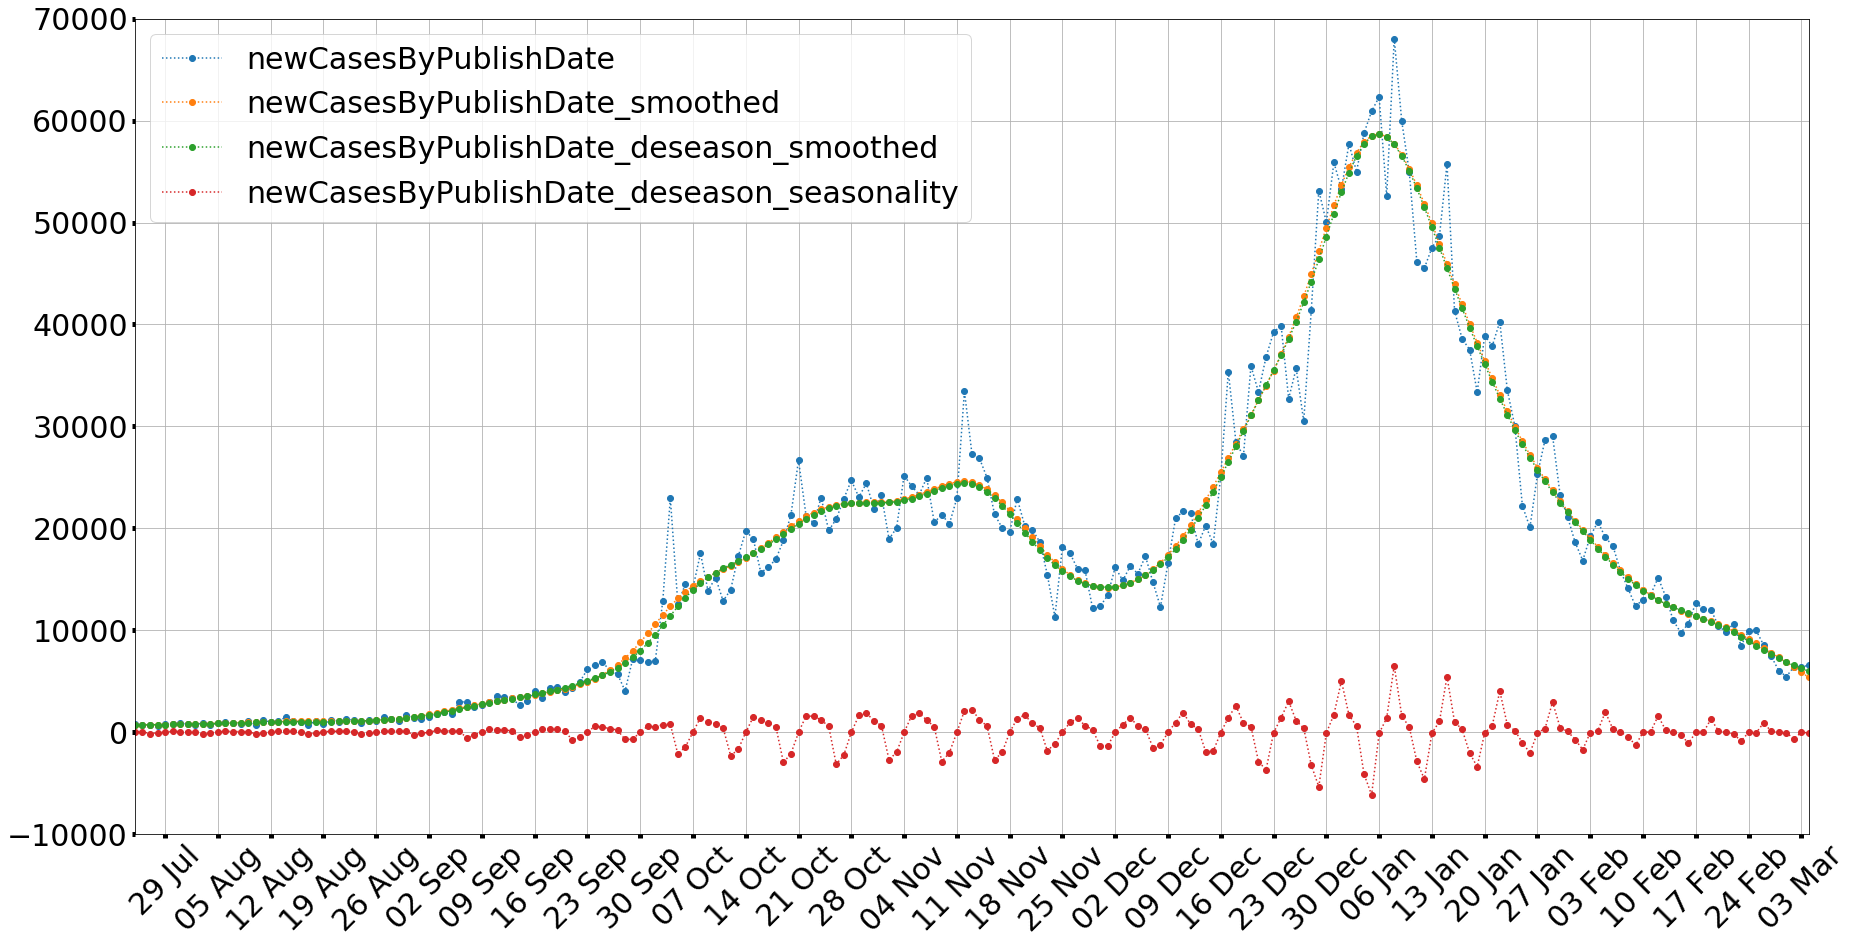

In [234]:
plotting.plot_series(
    df=GUK_data,
    xfield='date',
    yfields=[
        'newCasesByPublishDate', 
        'newCasesByPublishDate_smoothed',
        'newCasesByPublishDate_deseason_smoothed',
        'newCasesByPublishDate_deseason_seasonality'
    ],
    xlim=(datetime(2020,7,25), GUK_data.date.max()),
    ylim=(-10000,70000),
    legend_loc="upper left"
)

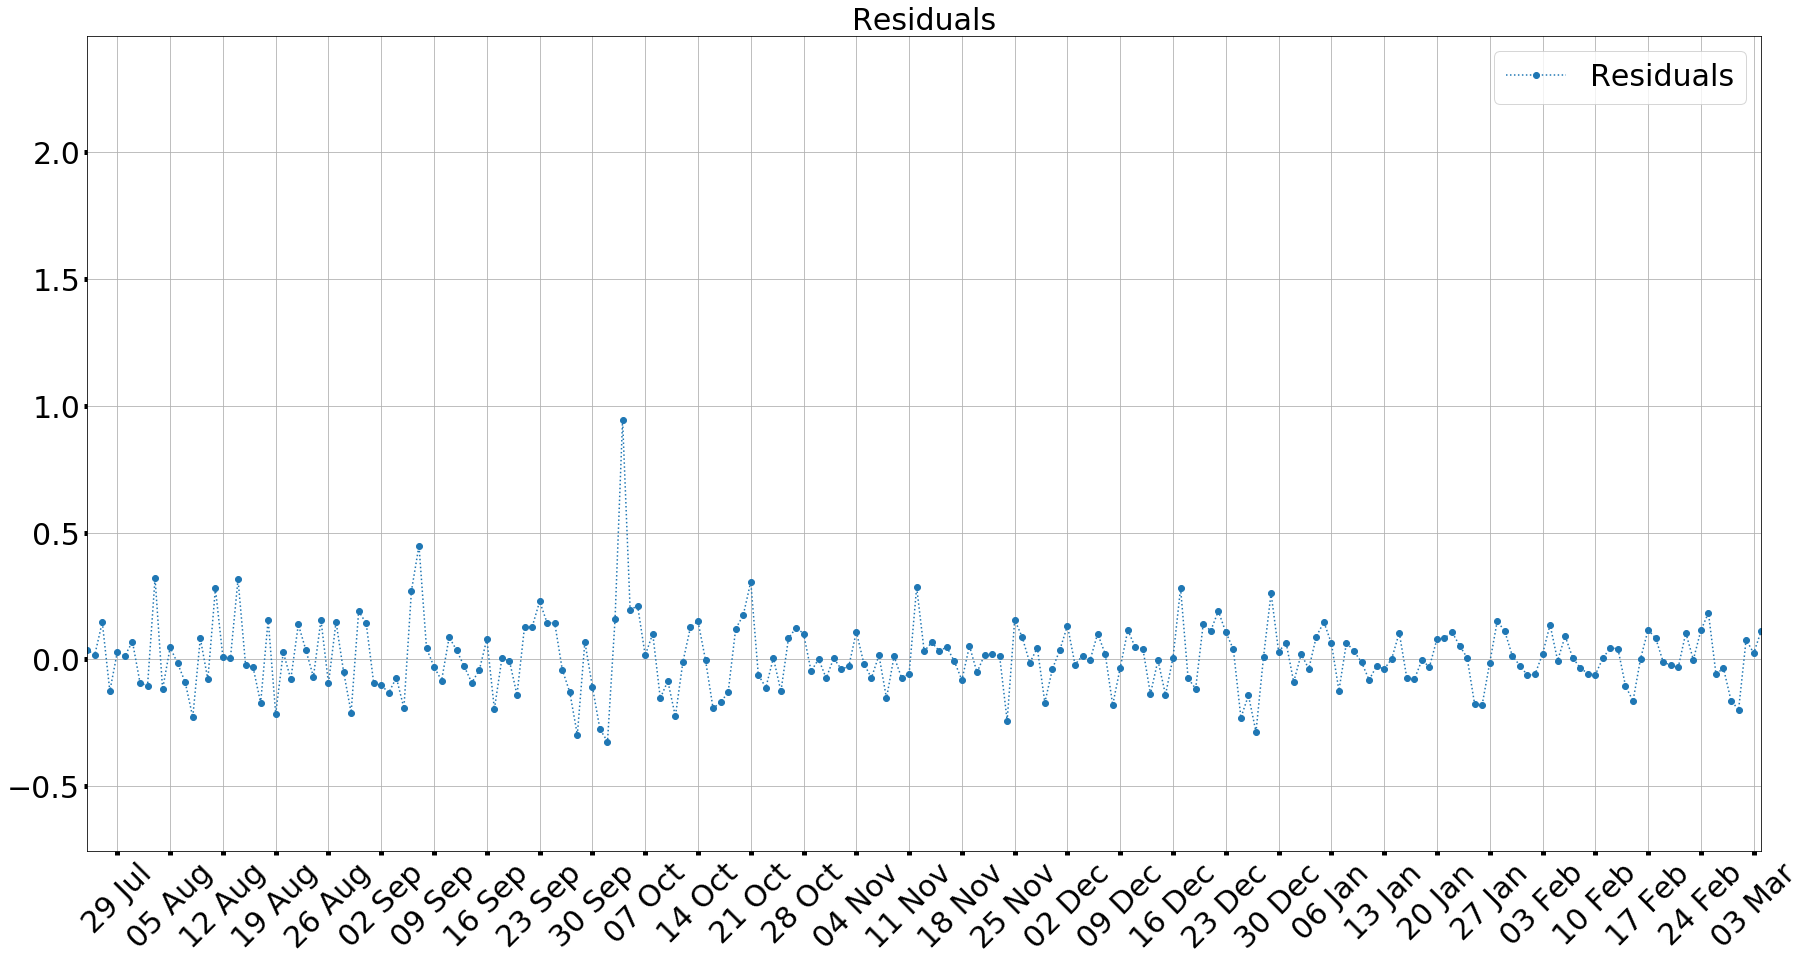

In [235]:
plotting.plot_series(
    title='Residuals',
    data=[{
        'df':GUK_data,
        'xfield': 'date',
        'yfields':[
            'newCasesByPublishDate_deseason_relative_residuals',
        ],
        'labels':[
            'Residuals',
        ]
    }],
    #img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'Rt_seasonality.{}'),
    xlim=(datetime(2020,7,25), GUK_data.date.max()),
    #ylim=(0.6,1.3),
    legend_loc="upper right"
)

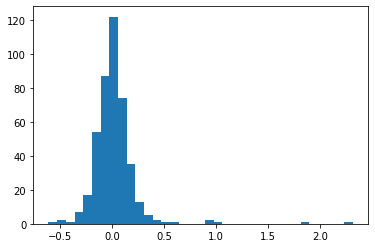

In [236]:
_=plt.hist(GUK_data.newCasesByPublishDate_deseason_relative_residuals,bins=35)

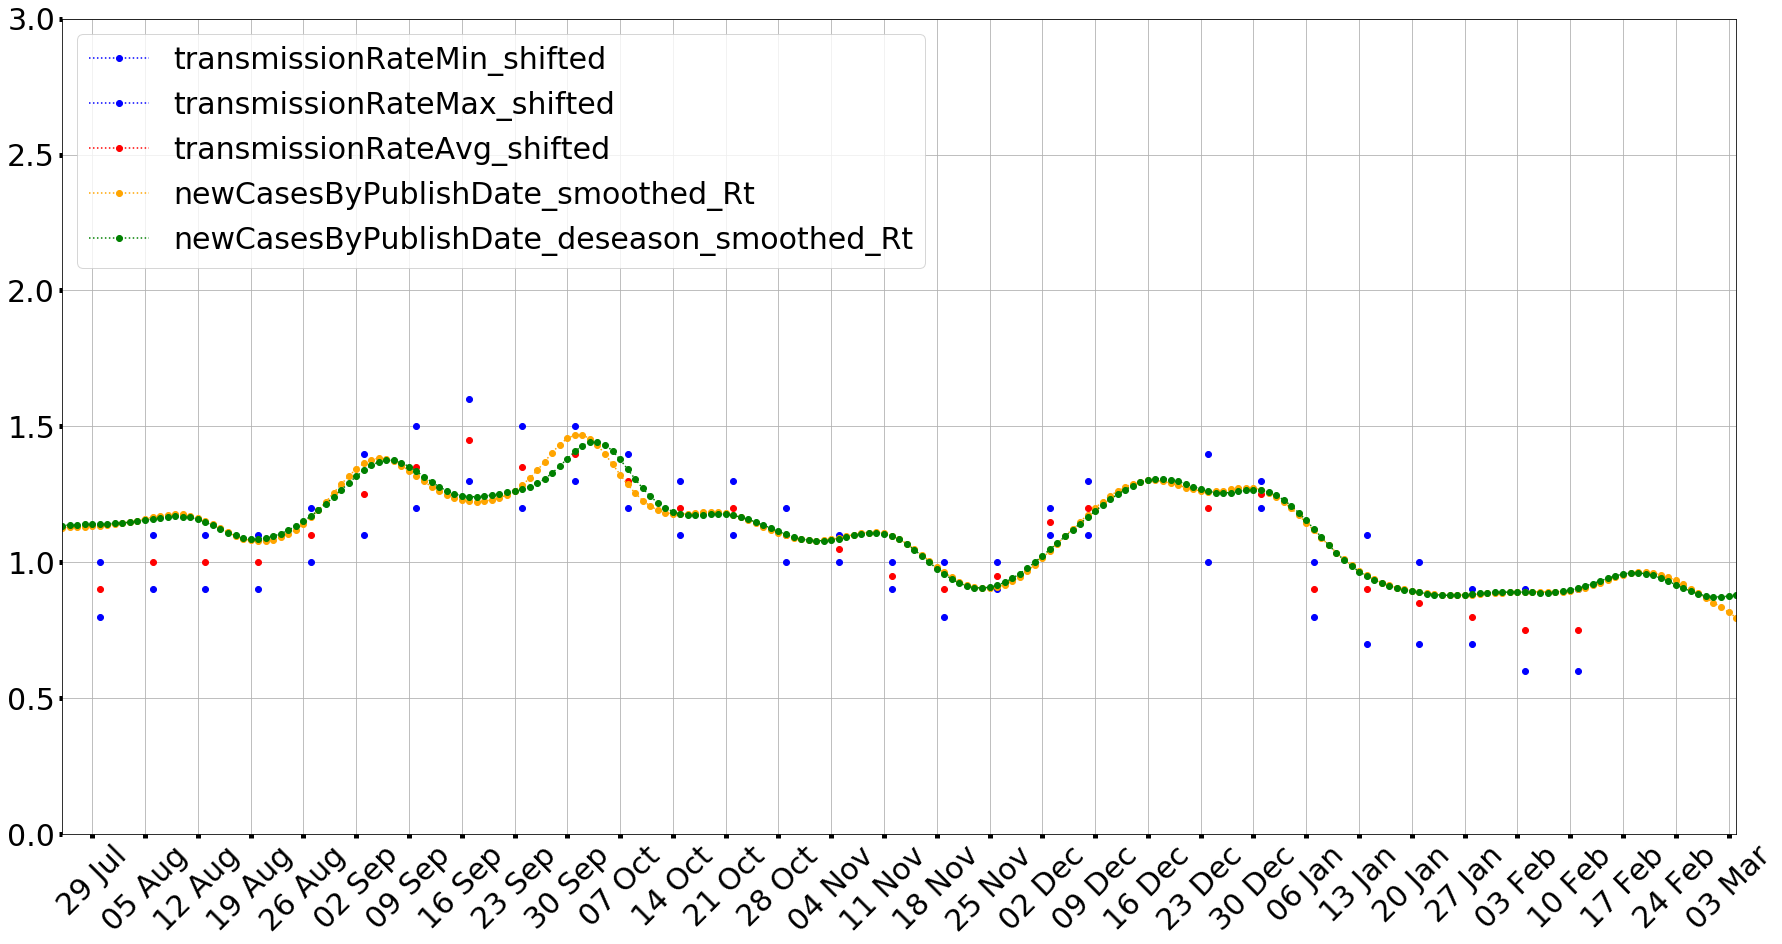

In [237]:
plotting.plot_series(
    data=[
        {
            'df':GUK_data,
            'xfield':'date',
            'yfields':[
                'transmissionRateMin_shifted', 
                'transmissionRateMax_shifted',
                'transmissionRateAvg_shifted',
                'newCasesByPublishDate_smoothed_Rt',
                'newCasesByPublishDate_deseason_smoothed_Rt'
            ],
            'colors':['blue', 'blue', 'red', 'orange', 'green']
        }
    ],
    xlim=(datetime(2020,7,25), GUK_data.date.max()),
    ylim=(0.,3),
    legend_loc="upper left"
)

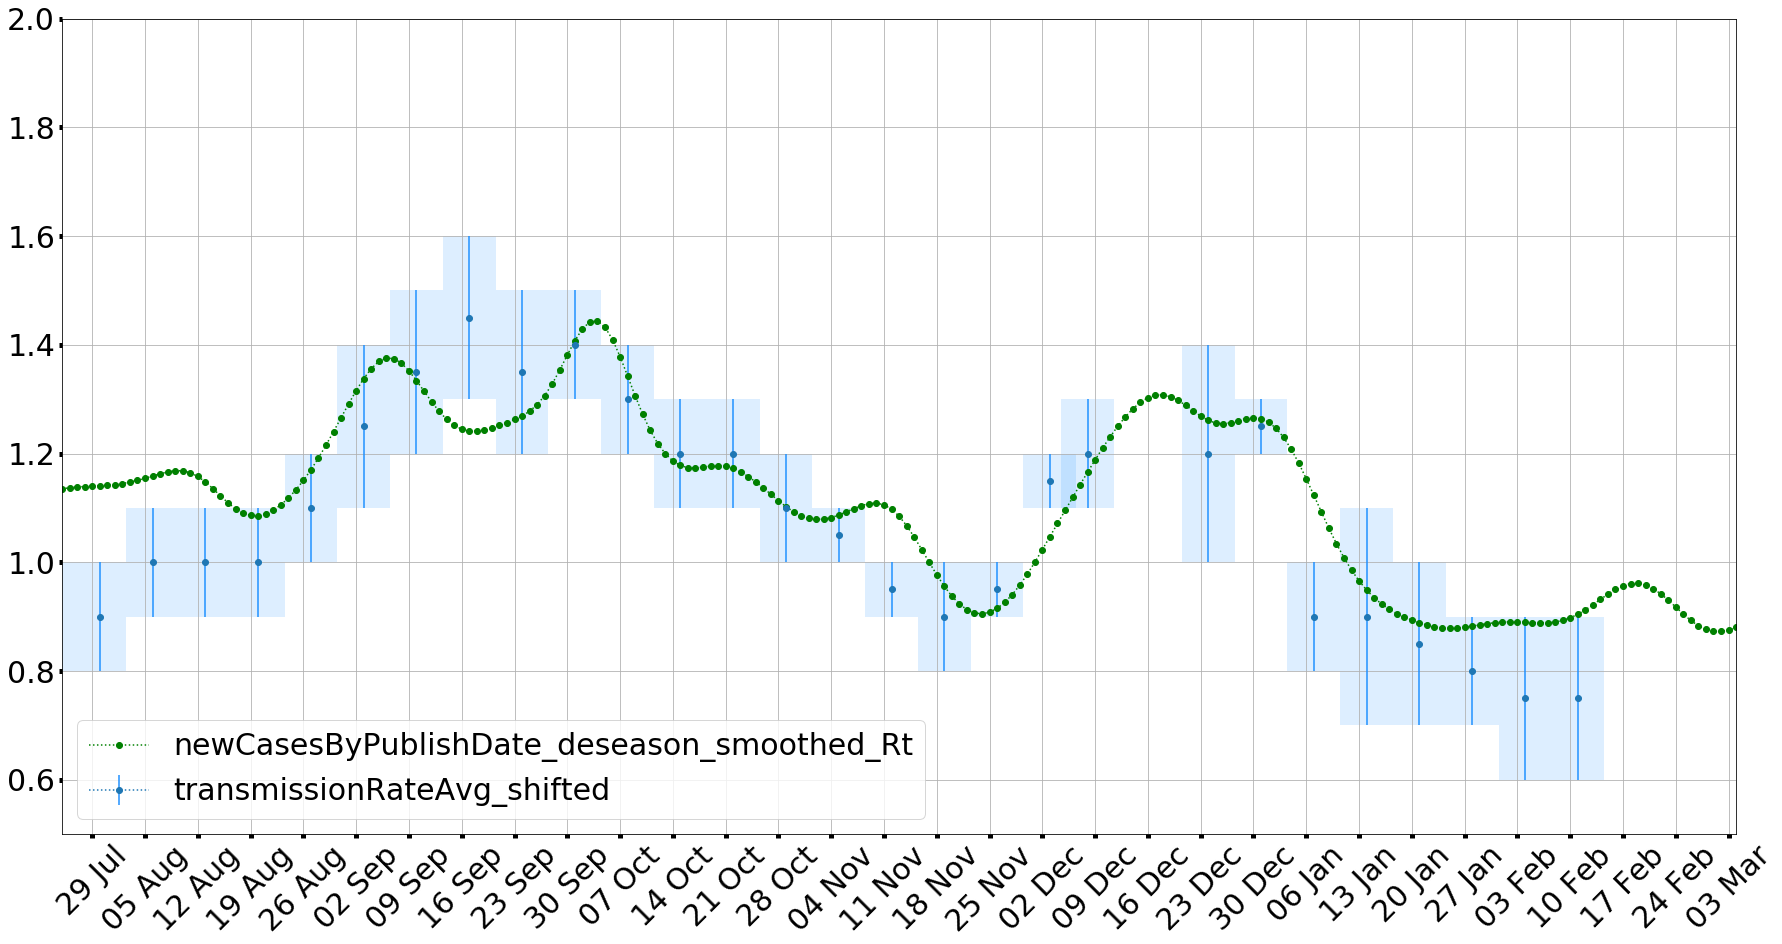

In [260]:
plotting.plot_series(
    data=[
        {
            'df':GUK_data,
            'xfield':'date',
            'yfields':[
                #'newCasesByPublishDate_smoothed_Rt',
                'newCasesByPublishDate_deseason_smoothed_Rt'
            ],
            'colors':['green']
        },
        {
            'df':GUK_data,
            'xfield':'date',
            'yfields':['transmissionRateAvg_shifted'],
            'bars':[['transmissionRateMinErr_shifted', 'transmissionRateMaxErr_shifted']],
            'timeranges': [['transmissionRateTimeRangeMin','transmissionRateTimeRangeMax']]
            #'colors':['blue', 'blue', 'orange']
        }        
    ],
    xlim=(datetime(2020,7,25), GUK_data.date.max()),
    ylim=(0.5,2),
    legend_loc="lower left",
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'UK_naive_Rt'),
    
)

In [239]:
def save_MCMC_sampling(df, column, trace, pastdays, interval=0.95, start=0):
    interval_frac = int(interval*100)
    sampling_mean = np.mean(trace['r_t'], axis=0)

    df[f'{column}_Rt_MCMC_pastdays_{pastdays:02d}'] = padnan(sampling_mean, (start,pastdays))
    

    #credible interval
    sampling_hdi = pm.stats.hpd(trace['r_t'], hdi_prob=interval)
    df[f'{column}_Rt_MCMC_HDI_{interval_frac}_min_pastdays_{pastdays:02d}'] = padnan(
        sampling_hdi[:,0], (start,pastdays))
    df[f'{column}_Rt_MCMC_HDI_{interval_frac}_max_pastdays_{pastdays:02d}'] = padnan(
        sampling_hdi[:,1], (start,pastdays))


In [ ]:
PASTDAYS_BEGIN=1

draws = 5

past_revisions=[]
future_revisions=[]
relative_residuals_sd=[]
actual_residuals=[]

STARTDAY = TIMESTEPS-250

for pastdays in range(PASTDAYS_BEGIN-1,-1,-1):
    print(f'\npastdays: {pastdays}')

    if pastdays == 0:
        sl = np.s_[STARTDAY:]
    else:
        sl = np.s_[STARTDAY:-pastdays]
        
    new_cases = GUK_data.newCasesByPublishDate.to_numpy()[sl]
    print(new_cases.shape)
    
    new_cases_expanded = draw_expanded_series(
            new_cases, draws=draws, season_period=7, trend_alpha=ALPHA, difference_degree=4, 
            alpha=alpha, beta=beta, truncate=False
        )
    
    print('pre smooth_and_drop')
    print(f'new_cases_expanded.shape: {new_cases_expanded.shape}')
    
    new_cases_smoothed, rel_eps, padding_left = smooth_and_drop(
        new_cases_expanded, season_period=7, trend_alpha=1000.,difference_degree=4)

    print('post smooth_and_drop')
    print(f'new_cases_smoothed.shape: {new_cases_smoothed.shape}')
    print(f'rel_eps.shape: {rel_eps.shape}')    
    print(f'padding_left: {padding_left}')
        
    simulations = []
    for new_cases_s, rel_eps_s in zip(new_cases_smoothed, rel_eps):
        print(f'new_cases_s cut left: {new_cases_s[~np.isnan(new_cases_s)].shape}')
        print(f'rel_eps_s cut left: {rel_eps_s[~np.isnan(rel_eps_s)].shape}')
        
        model_, trace_ = MCMC_sample(
            onset=new_cases_s[~np.isnan(new_cases_s)],
            alpha=alpha, beta=beta,
            rel_eps=rel_eps_s[~np.isnan(rel_eps_s)],
            eps_window=1,
            start=0, window=None,
            chains=4,
            tune=500,
            draws=500,
            cores=4,
            dry=False,
            target_accept=0.99,
            max_treedepth=12,
            progressbar=False
        )
        simulations.append(trace_)

    sampled_Rt = np.array([t['r_t'] for t in simulations])
    combined_trace = {'r_t': sampled_Rt.reshape((-1,sampled_Rt.shape[2]))}

    save_MCMC_sampling(
        GUK_data, 'newCasesByPublishDate_smooth_deseas', combined_trace, pastdays, interval=0.95, start=padding_left+1+(TIMESTEPS-250))

    
    #GUK_data.to_pickle(os.path.join(BASE_DATA_PATH,'computed/WIP/deseason_MCMC_Rt.pickle'))

In [284]:
# load MCMC simulations calculated on our cloud
GUK_futbound_calc_data = pd.read_pickle(os.path.join(
    BASE_DATA_PATH,'computed/UK/20200304_UK_Rt_realtime_calc.pickle'))

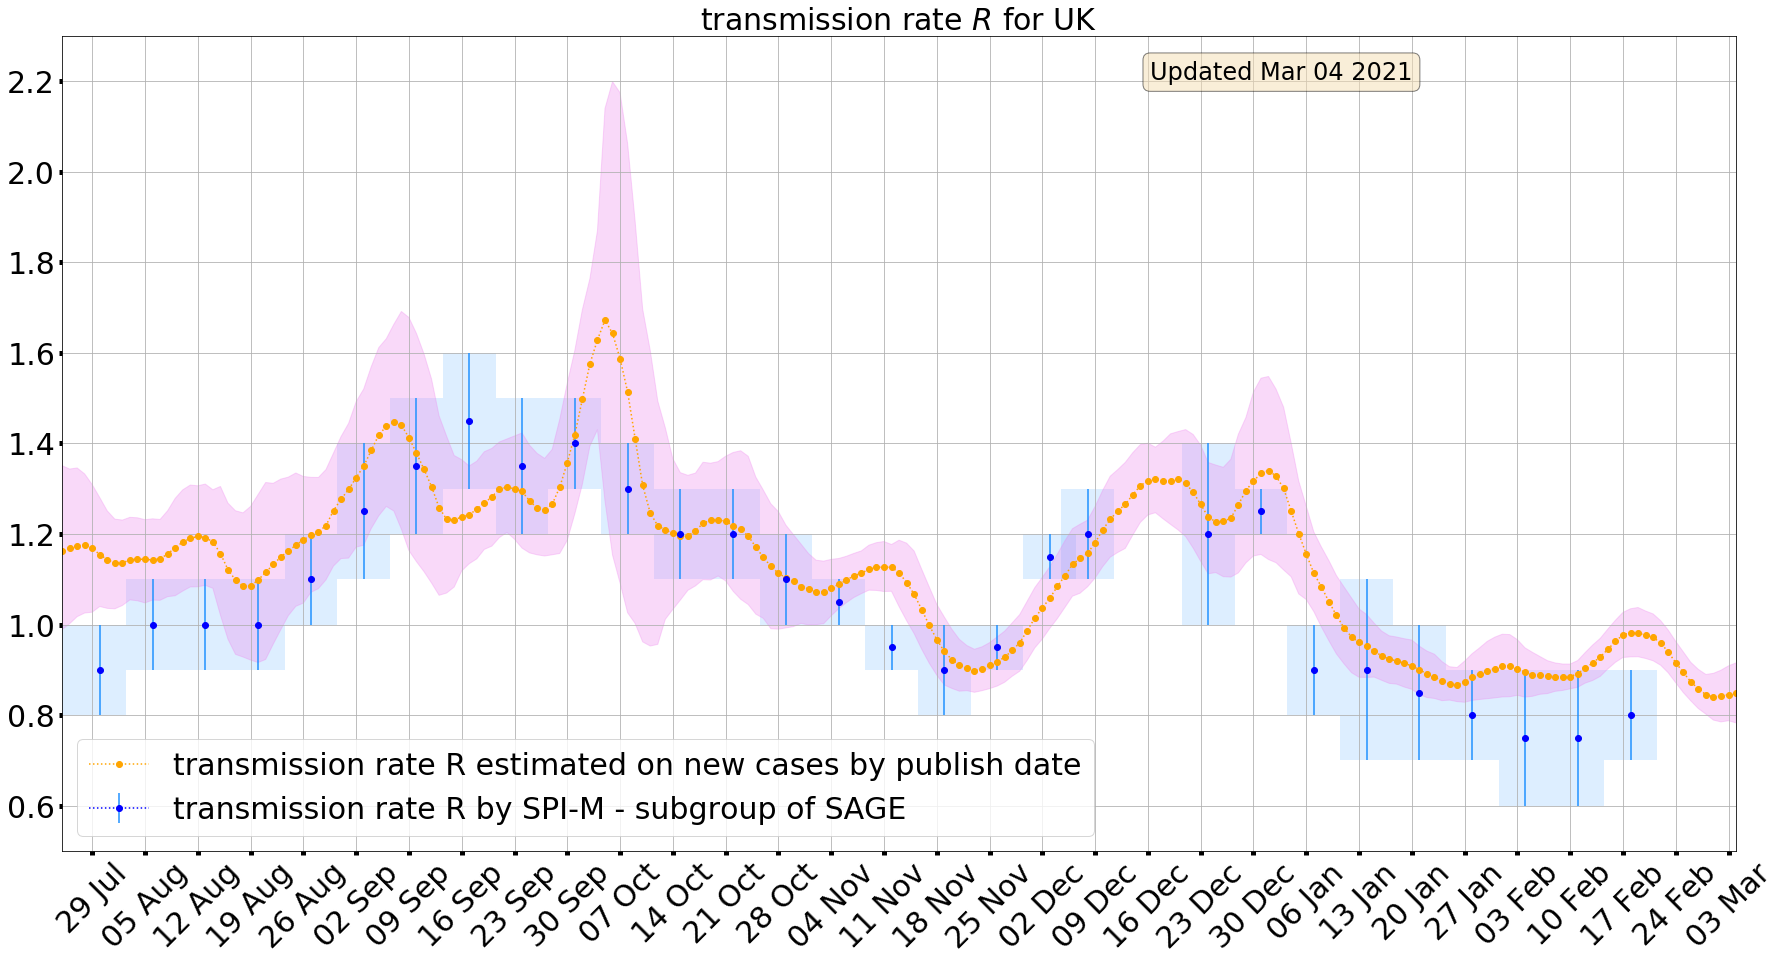

In [285]:
curdate = GUK_futbound_calc_data.date.max()
plotting.plot_series(
    title='transmission rate $R$ for UK'.format(curdate, pastdays),
    message='Updated {}'.format(GUK_futbound_calc_data.date.max().strftime('%b %d %Y')),
    data=[
        {
            'df':GUK_Rt_data,
            'xfield':'date',
            'yfields':['transmissionRateAvg_shifted'],
            'bars':[['transmissionRateMinErr_shifted', 'transmissionRateMaxErr_shifted']],
            'timeranges': [['transmissionRateTimeRangeMin','transmissionRateTimeRangeMax']],
            'labels': ['transmission rate R by SPI-M - subgroup of SAGE'],
            'colors':['blue']
        },        
        {
            'df': GUK_futbound_calc_data,
            'xfield': 'date',
            'yfields': [
                'newCasesByPublishDate_smooth_deseas_Rt_MCMC_pastdays_000'
            ],
            'fill_between': [
                f'newCasesByPublishDate_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_000',
                f'newCasesByPublishDate_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_000',
            ],
            'labels': [
                f'transmission rate R estimated on new cases by publish date',
            ],
            'colors':['orange']
        }
    ],
    xlim=(datetime(2020,7,25), GUK_futbound_calc_data.date.max()),
    ylim=(0.5,2.3),
    legend_loc='lower left',
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,f'worldwide/UK/Rt_{curdate.isoformat()}'),
    #dpi=70,
    #quality=40
)

### Note:

As the only available date for the official numbers is the **publish date**, the position in time of those follows an assumption: we place them in the week spanning from 21 to 14 days before the publication date.

The assumption is based on the following note available [here](https://www.gov.uk/guidance/the-r-number-in-the-uk#about-r-and-growth-rate):
> **Time delay of the estimates**
>
> SPI-M use several models, each using data from a variety of sources in their estimates of R and growth rate. Epidemiological data, such as hospital admissions, ICU admissions and deaths, usually takes up to 3 weeks to reflect changes in the spread of disease.
>
> This is due to the time delay between initial infection, having symptoms and the need for hospital care. As a result, the latest published figures represent the situation over the past few weeks rather than today. These estimates do not yet fully reflect any very recent changes in transmission due to, for example, recent policy changes in the UK.